# Import libraries

In [ ]:
!pip install sentencepiece
!pip install tokenizers
!pip install transformers
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 41.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 30.6 MB/s eta 0:00:00


In [ ]:
import os, re
import numpy as np
import pandas as pd
np.random.seed(2020)

import nltk
nltk.download('all') # one time execution
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize


#---------------------------------------------------------------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare Data

In [ ]:
data = pd.read_csv(r'/content/drive/MyDrive/data_final.csv')
data.head()

,Unnamed: 0,song name,song lyric,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,0,world so cold,"It starts with pain, followed by hate\nFueled ...",0,0,0,0,0,1
1,1,broken,Freedom!\nAlone again again alone\nPatiently w...,0,0,0,0,0,1
2,2,3 leaf loser,"Biting the hand that feeds you, lying to the v...",0,0,0,0,0,1
3,3,anthem for the underdog,You say you know just who I am\nBut you can't ...,0,0,0,0,0,1
4,4,adrenaline,My heart is beating faster can't control these...,0,0,0,0,0,1


In [ ]:
data.dropna()
data = data.drop(columns=['Unnamed: 0'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20339 entries, 0 to 20338
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song name   20339 non-null  object
 1   song lyric  20339 non-null  object
 2   COUNTRY     20339 non-null  int64 
 3   HIPHOP      20339 non-null  int64 
 4   INDIE       20339 non-null  int64 
 5   JAZZ        20339 non-null  int64 
 6   POP         20339 non-null  int64 
 7   ROCK        20339 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.2+ MB


In [ ]:
data = data.rename(columns = {"song name": "song_name",
                              "song lyric": "song_lyric"})
data = data.astype(np.str)
data.head()

<ipython-input-6-b4312f7f36ec>:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.str)


,song_name,song_lyric,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,world so cold,"It starts with pain, followed by hate\nFueled ...",0,0,0,0,0,1
1,broken,Freedom!\nAlone again again alone\nPatiently w...,0,0,0,0,0,1
2,3 leaf loser,"Biting the hand that feeds you, lying to the v...",0,0,0,0,0,1
3,anthem for the underdog,You say you know just who I am\nBut you can't ...,0,0,0,0,0,1
4,adrenaline,My heart is beating faster can't control these...,0,0,0,0,0,1


# Text Preprocessing

In [ ]:
import pandas as pd
import re
import string
import contractions
contractions_dict = {"ain't": "are not",
                     "'s":" is",
                     "aren't": "are not",
                     "'fore": "before", 
                     "i've": "i have", 
                     "you've": "you have",
                     "wanna": "want to", 
                     "gotta": "have got to",
                     "gonna": "going to",
                     "ima": "i am going to",
                     "you'll": "you will",
                     "i'll": "i will"}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
class TextPreprocessor:

    def __init__(self, dataframe):    
        self.df = dataframe

    # delete punctuations
    def remove_punctuation(self, text):       
        return re.sub(f'[{string.punctuation}]', '', text)

    # lower texts
    def to_lowercase(self, text):       
        return text.lower()
    
     # remove numbers
    def remove_numbers(self, text):     
        return re.sub(r'\d+', '', text)
    
     # remove extra white spaces
    def remove_whitespaces(self, text):      
        return text.strip()
    
     # expand contradiction
    def expand_contraction(self, text, contractions_dict = contractions_dict):     
        expanded_words = []   
        for word in text.split():
            expanded_words.append(contractions.fix(word))  
        expanded_text = ' '.join(expanded_words)

        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, expanded_text)
    
     # delete non-english words
    def del_nonEnglish(self, text):      
        text = re.sub(r'\W+', ' ', text)
        text = text.lower()
        text = text.replace("[^a-zA-Z]", " ")
        word_tokens = word_tokenize(text)
        filtered_word = [w for w in word_tokens if all(ord(c) < 128 for c in w)]
        filtered_word = [w + " " for w in filtered_word]
        return "".join(filtered_word)
    
     # remove stopwords
    def remove_stopwords(self, text):    
        global stop_words
        try:
            word_tokens = word_tokenize(text)
            filtered_word = [w for w in word_tokens if not w in stop_words]
            filtered_word = [w + " " for w in filtered_word]
            return "".join(filtered_word)
        except:
            return np.nan

     #lemmatize
    def normalization(self, text):      
        global lemmatizer
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    
    def preprocess_text(self):
        self.df['name_pp'] = self.df.song_name.apply(self.to_lowercase)
        self.df['name_pp'] = self.df.name_pp.apply(self.expand_contraction)
        self.df['name_pp'] = self.df.name_pp.apply(self.remove_punctuation)
        self.df['name_pp'] = self.df.name_pp.apply(self.del_nonEnglish)
        self.df['name_pp'] = self.df.name_pp.apply(self.remove_stopwords)
        self.df['name_pp'] = self.df.name_pp.apply(self.normalization)
        self.df['name_pp'] = self.df.name_pp.apply(self.remove_whitespaces)
        self.df['name_pp'] = self.df.name_pp.apply(self.remove_numbers)

        self.df['lyric_pp'] = self.df.song_lyric.apply(self.to_lowercase)
        self.df['lyric_pp'] = self.df.lyric_pp.apply(self.expand_contraction)
        self.df['lyric_pp'] = self.df.lyric_pp.apply(self.remove_punctuation)
        self.df['lyric_pp'] = self.df.lyric_pp.apply(self.del_nonEnglish)
        self.df['lyric_pp'] = self.df.lyric_pp.apply(self.remove_stopwords)
        self.df['lyric_pp'] = self.df.lyric_pp.apply(self.normalization)
        self.df['lyric_pp'] = self.df.lyric_pp.apply(self.remove_whitespaces)
        self.df['lyric_pp'] = self.df.lyric_pp.apply(self.remove_numbers)
        
        return self.df


In [ ]:
data = TextPreprocessor(data).preprocess_text()

In [ ]:
target_list = ['COUNTRY',	'HIPHOP',	'INDIE',	'JAZZ',	'POP',	'ROCK']
# data = data.drop(columns=['song_name', 'song_lyric']
data['category'] = data[target_list].values.argmax(1)
data.head()

,song_name,song_lyric,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK,name_pp,lyric_pp,category
0,world so cold,"It starts with pain, followed by hate\nFueled ...",0,0,0,0,0,1,world cold,start pain followed hate fueled endless questi...,5
1,broken,Freedom!\nAlone again again alone\nPatiently w...,0,0,0,0,0,1,broken,freedom alone alone patiently waiting phone ho...,5
2,3 leaf loser,"Biting the hand that feeds you, lying to the v...",0,0,0,0,0,1,leaf loser,biting hand feed lying voice inside reach beg ...,5
3,anthem for the underdog,You say you know just who I am\nBut you can't ...,0,0,0,0,0,1,anthem underdog,say know going togine wait across line thought...,5
4,adrenaline,My heart is beating faster can't control these...,0,0,0,0,0,1,adrenaline,heart beating faster control feeling anymore w...,5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20339 entries, 0 to 20338
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_name   20339 non-null  object
 1   song_lyric  20339 non-null  object
 2   COUNTRY     20339 non-null  object
 3   HIPHOP      20339 non-null  object
 4   INDIE       20339 non-null  object
 5   JAZZ        20339 non-null  object
 6   POP         20339 non-null  object
 7   ROCK        20339 non-null  object
 8   name_pp     20339 non-null  object
 9   lyric_pp    20339 non-null  object
 10  category    20339 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.7+ MB


# MODELS

## Create Train_Test sets

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [ ]:
data = data.astype({"COUNTRY":'int64', "HIPHOP":'int64', "INDIE":'int64', "JAZZ":'int64', "POP":'int64', "ROCK":'int64'})

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20339 entries, 0 to 20338
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_name   20339 non-null  object
 1   song_lyric  20339 non-null  object
 2   COUNTRY     20339 non-null  int64 
 3   HIPHOP      20339 non-null  int64 
 4   INDIE       20339 non-null  int64 
 5   JAZZ        20339 non-null  int64 
 6   POP         20339 non-null  int64 
 7   ROCK        20339 non-null  int64 
 8   name_pp     20339 non-null  object
 9   lyric_pp    20339 non-null  object
 10  category    20339 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1.7+ MB


In [ ]:
# tl = ['category', 'COUNTRY',	'HIPHOP',	'INDIE',	'JAZZ',	'POP',	'ROCK']
target_list = ['COUNTRY',	'HIPHOP',	'INDIE',	'JAZZ',	'POP',	'ROCK']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data['lyric_pp'], data[target_list], test_size=0.1, random_state=0)
x_train.shape, y_train.shape

((18305,), (18305, 6))

In [ ]:
train_df = pd.concat([pd.DataFrame({"lyric_pp": x_train}), y_train], axis=1)
train_df.reset_index(inplace = True)
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18305 entries, 0 to 18304
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     18305 non-null  int64 
 1   lyric_pp  18305 non-null  object
 2   COUNTRY   18305 non-null  int64 
 3   HIPHOP    18305 non-null  int64 
 4   INDIE     18305 non-null  int64 
 5   JAZZ      18305 non-null  int64 
 6   POP       18305 non-null  int64 
 7   ROCK      18305 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 1.1+ MB
None


,index,lyric_pp,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,19633,wait minute baby stay said would give light ne...,0,0,0,0,0,1
1,14874,two jump week bet think pretty clever boy flyi...,0,0,1,0,0,0
2,12617,saw last night sittin alone bar came back even...,1,0,0,0,0,0
3,16984,balloon deflated guess look lifeless like miss...,0,0,0,1,0,0
4,4211,pack trouble get happy ya better chase care aw...,0,0,0,1,0,0


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_df['lyric_pp'], train_df[target_list], test_size=0.1, random_state=0)
x_train.shape, y_train.shape

((16474,), (16474, 6))

In [ ]:
train_df = pd.concat([pd.DataFrame({"lyric_pp": x_train}), y_train], axis=1)
train_df.reset_index(inplace = True)
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16474 entries, 0 to 16473
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     16474 non-null  int64 
 1   lyric_pp  16474 non-null  object
 2   COUNTRY   16474 non-null  int64 
 3   HIPHOP    16474 non-null  int64 
 4   INDIE     16474 non-null  int64 
 5   JAZZ      16474 non-null  int64 
 6   POP       16474 non-null  int64 
 7   ROCK      16474 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 1.0+ MB
None


,index,lyric_pp,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,11620,yeah uh east point smoke dank college park hou...,0,1,0,0,0,0
1,18242,nothing way supposed swingin fence every oppor...,1,0,0,0,0,0
2,10403,everyone saying break heart agree love everyon...,0,0,0,1,0,0
3,15294,yes god want devil house god yes lord want lor...,0,1,0,0,0,0
4,3259,boy crimson rag gri going toce spoon little su...,0,0,0,0,1,0


In [ ]:
val_df = pd.concat([pd.DataFrame({"lyric_pp": x_val}), y_val], axis=1)
val_df.reset_index(inplace = True)
print(val_df.info())
val_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     1831 non-null   int64 
 1   lyric_pp  1831 non-null   object
 2   COUNTRY   1831 non-null   int64 
 3   HIPHOP    1831 non-null   int64 
 4   INDIE     1831 non-null   int64 
 5   JAZZ      1831 non-null   int64 
 6   POP       1831 non-null   int64 
 7   ROCK      1831 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 114.6+ KB
None


,index,lyric_pp,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,861,laughed loud til cried tear sweet midnight mel...,0,0,1,0,0,0
1,8971,hm hm uh uh uh uh uh woah uh uh uh uh yeah foo...,0,1,0,0,0,0
2,3982,yeah sunday morning rain falling steal cover s...,0,0,0,0,1,0
3,2826,ask tree blossom spring leave house midnight e...,0,0,0,1,0,0
4,12956,intro e b g d a e verse e b g d a e chorus e ...,0,0,0,0,1,0


In [ ]:
test_df = pd.concat([pd.DataFrame({"lyric_pp": x_test}), y_test], axis=1)
test_df.reset_index(inplace = True)
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     2034 non-null   int64 
 1   lyric_pp  2034 non-null   object
 2   COUNTRY   2034 non-null   int64 
 3   HIPHOP    2034 non-null   int64 
 4   INDIE     2034 non-null   int64 
 5   JAZZ      2034 non-null   int64 
 6   POP       2034 non-null   int64 
 7   ROCK      2034 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 127.2+ KB
None


,index,lyric_pp,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,13313,tahj money touchoftrent wilding go friend forg...,0,1,0,0,0,0
1,6398,steppin club tooled like thug rubadubdub rubar...,0,0,1,0,0,0
2,11139,well hundred year cry hundred year blue heart ...,1,0,0,0,0,0
3,9462,old smoke filled bar something used gave home ...,1,0,0,0,0,0
4,14499,said baby afraid fall love reciprocated told r...,0,0,1,0,0,0


## Custom dataset and create dataloader

In [ ]:
!nvidia-smi

Sat Feb 11 18:42:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, XLNetTokenizer, XLNetModel
import torch
from torch.utils.data import DataLoader, Dataset

In [ ]:
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# token_dict = {
#     'BertTokenizer': BertTokenizer.from_pretrain('bert-base-uncased'),
#     'RobertaTokenizer': RobertaTokenizer.from_pretrained('roberta-base'),
#     'XLNetTokenizer': XLNetTokenizer.from_pretrained("xlnet-base-cased")
# }

In [ ]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['lyric_pp']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN)

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
     

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Model Classes


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
# class BERT_BiLSTM_CNN(nn.Module):
#     def __init__(self, num_classes):
#         super(BERT_BiLSTM_CNN, self).__init__()
        
#         self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
#         self.lstm = nn.LSTM(bidirectional=True, num_layers=3, input_size=768, hidden_size=256, batch_first=True)
#         self.fc = nn.Linear(512, 128)
#         self.dropout = nn.Dropout(0.5)
#         self.conv1 = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1)
#         self.fc2 = nn.Linear(32, num_classes)
        
#     def forward(self, input_ids, attention_mask, token_type_ids):
#         bert_outputs = self.bert(
#             input_ids, 
#             attention_mask=attention_mask, 
#             token_type_ids=token_type_ids
#         )

#         sequence_output = bert_outputs.last_hidden_state
#         lstm_output, _ = self.lstm(sequence_output)
#         x = self.fc(lstm_output[:, -1])
#         x = self.dropout(x)
#         x = x.permute(0, 2, 1)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x, _ = torch.max(x, dim=-1)
#         x = self.fc2(x)
#         return x

# model = BERT_BiLSTM_CNN(num_classes=6)
# model.to(device)


In [ ]:
class BERT_CNN(nn.Module):
    def __init__(self, num_classes):
        super(BERT_CNN, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.5)
        self.conv1 = nn.Conv1d(768, 128, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              return_dict=True)
        last_hidden_state = output.last_hidden_state
        x = self.dropout(last_hidden_state)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x, _ = torch.max(x, dim=-1)
        x = self.fc(x)
        return x

model = BERT_CNN(num_classes=6)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT_CNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
class BERT_BiLSTM(nn.Module):
    def __init__(self, num_labels, dropout=0.1):
        super(BERT_BiLSTM, self).__init__()
        
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.bilstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=2, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_features=2 * 256, out_features=self.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert(input_ids=input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
        last_hidden_state = output.last_hidden_state
        bilstm_out, _ = self.bilstm(last_hidden_state.permute(1,0,2))
        bilstm_out = bilstm_out.permute(1,0,2)
        bilstm_out = self.dropout(bilstm_out[:,-1,:])
        logits = self.fc(bilstm_out)
        
        return logits

model = BERT_BiLSTM(num_labels=6)
model.to(device)

In [ ]:
# class BERTClass(nn.Module):
#     def __init__(self):
#         super(BERTClass, self).__init__()
#         self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.linear = torch.nn.Linear(768, 6)
    
#     def forward(self, input_ids, attn_mask, token_type_ids):
#         output = self.bert_model(
#             input_ids, 
#             attention_mask=attn_mask, 
#             token_type_ids=token_type_ids
#         )

#         output_dropout = self.dropout(output.pooler_output)
#         output = self.linear(output_dropout)
#         return output

# model = BERTClass()
# model.to(device)

In [ ]:
# class XLNetClassification(nn.Module):
#     def __init__(self, num_classes):
#         super(XLNetClassification, self).__init__()
#         self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
#         self.dropout = nn.Dropout(0.2)
#         self.fc = nn.Linear(768, num_classes)

#     def forward(self, input_ids, attention_mask, token_type_ids):
#         xlnet_output = self.xlnet(
#             input_ids=input_ids, 
#             attention_mask=attention_mask, 
#             token_type_ids=token_type_ids, 
#             return_dict=True
#         )

#         last_hidden_state = xlnet_output.last_hidden_state
#         avg_pool = torch.mean(last_hidden_state, 1)
#         avg_pool = self.dropout(avg_pool)
#         logits = self.fc(avg_pool)
#         return logits


# # Initialize the model with number of labels and XLNet model name
# model = XLNetClassification(num_classes=6)
# model.to(device)

## Training model

In [ ]:
data_dir = "/content"

In [ ]:
from collections import defaultdict

In [ ]:
count = 1
for val in train_data_loader:
    print(val['input_ids'].shape)
    print(val['token_type_ids'].shape)
    print(val['attention_mask'].shape)
    count -= 1
    if count == 0:
        break

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])


In [ ]:
def trainer(n_epochs, training_loader, validation_loader, 
            model, data_dir):
  
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

    def train_model(training_loader, model, optimizer):
        losses = []
        correct_predictions = 0
        num_samples = 0

        model.train()
        for batch_idx, data in enumerate(training_loader):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            # training accuracy
            _, preds = torch.max(outputs, dim=1) 
            _, targ = torch.max(targets, dim=1)
            num_samples += len(targ)
            correct_predictions += torch.sum(preds == targ)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        return model, float(correct_predictions)/num_samples, np.mean(losses)

    def eval_model(validation_loader, model, optimizer):
        losses = []
        correct_predictions = 0
        num_samples = 0

        model.eval()

        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader, 0):
                ids = data['input_ids'].to(device, dtype = torch.long)
                mask = data['attention_mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = model(ids, mask, token_type_ids)

                loss = criterion(outputs, targets)
                losses.append(loss.item())

                # validation accuracy
                _, preds = torch.max(outputs, dim=1) 
                _, targ = torch.max(targets, dim=1)
                num_samples += len(targ)
                correct_predictions += torch.sum(preds == targ)

        return float(correct_predictions)/num_samples, np.mean(losses)

    
    history = defaultdict(list)
    best_accuracy = 0

    print('########################## Training Start ##########################')

    for epoch in range(1, EPOCHS+1):
        print(f'Epoch {epoch}/{EPOCHS}')
        model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
        val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

        print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        # save the best model
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), os.path.join(data_dir,"best_model_state.bin"))
            best_accuracy = val_acc
    
    print('########################## Accuracy: {:.4f} ##########################'.format(best_accuracy))

In [ ]:
train_model = trainer(EPOCHS, train_data_loader, val_data_loader, model, data_dir)

########################## Training Start ##########################
Epoch 1/10
train_loss=0.4499, val_loss=0.3877 train_acc=0.2832, val_acc=0.4397
Epoch 2/10
train_loss=0.3578, val_loss=0.3393 train_acc=0.4664, val_acc=0.5085
Epoch 3/10
train_loss=0.3158, val_loss=0.3251 train_acc=0.5395, val_acc=0.5199
Epoch 4/10
train_loss=0.2799, val_loss=0.3189 train_acc=0.6124, val_acc=0.5702
Epoch 5/10
train_loss=0.2460, val_loss=0.3115 train_acc=0.6738, val_acc=0.5849
Epoch 6/10
train_loss=0.2132, val_loss=0.3126 train_acc=0.7339, val_acc=0.5948
Epoch 7/10
train_loss=0.1834, val_loss=0.3206 train_acc=0.7791, val_acc=0.6035
Epoch 8/10
train_loss=0.1551, val_loss=0.3371 train_acc=0.8269, val_acc=0.5931
Epoch 9/10
train_loss=0.1314, val_loss=0.3568 train_acc=0.8606, val_acc=0.5937
Epoch 10/10
train_loss=0.1120, val_loss=0.3632 train_acc=0.8845, val_acc=0.5904
########################## Accuracy: 0.6035 ##########################


## Confusion Matrix



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    lyrics = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
        for data in data_loader:
            text = data["title"]
            ids = data["input_ids"].to(device, dtype = torch.long)
            mask = data["attention_mask"].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data["targets"].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            _, preds = torch.max(outputs, dim=1)
            _, targ = torch.max(targets, dim=1)

            lyrics.extend(text)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targ)
        
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    target_values = torch.stack(target_values).cpu()
    
    return lyrics, predictions, prediction_probs, target_values

In [ ]:
lyrics, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [ ]:
# Classification report
print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

     COUNTRY       0.69      0.71      0.70       329
      HIPHOP       0.85      0.76      0.80       348
       INDIE       0.45      0.51      0.48       354
        JAZZ       0.63      0.57      0.60       356
         POP       0.47      0.46      0.47       328
        ROCK       0.52      0.56      0.54       319

    accuracy                           0.60      2034
   macro avg       0.60      0.59      0.60      2034
weighted avg       0.60      0.60      0.60      2034



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True category')
    plt.xlabel('Predicted category');

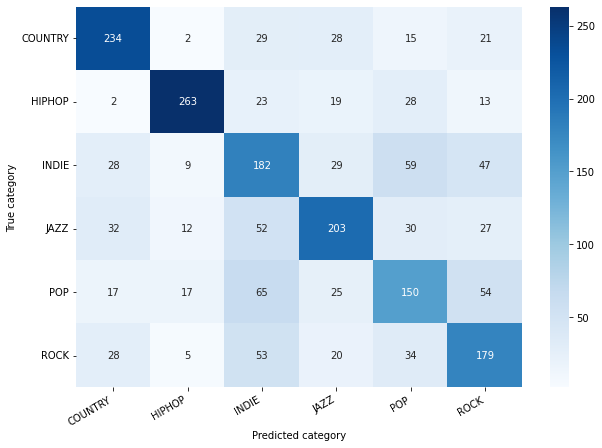

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
cm = confusion_matrix(target_values, predictions)
df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
show_confusion_matrix(df_cm)

## Predict on raw texts
 

In [ ]:
test_df.columns[3:]

Index(['HIPHOP', 'INDIE', 'JAZZ', 'POP', 'ROCK'], dtype='object')

In [ ]:
# testing
example = test_df['lyric_pp'][2]
encodings = tokenizer.encode_plus(
    example,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
model.eval()
with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    print(train_df.columns[3:].to_list()[int(np.argmax(final_output, axis=1))])

HIPHOP


In [ ]:
test_df.head()

,index,lyric_pp,COUNTRY,HIPHOP,INDIE,JAZZ,POP,ROCK
0,13313,tahj money touchoftrent wilding go friend forg...,0,1,0,0,0,0
1,6398,steppin club tooled like thug rubadubdub rubar...,0,0,1,0,0,0
2,11139,well hundred year cry hundred year blue heart ...,1,0,0,0,0,0
3,9462,old smoke filled bar something used gave home ...,1,0,0,0,0,0
4,14499,said baby afraid fall love reciprocated told r...,0,0,1,0,0,0
